# Hole Detection Using Beat Detection
05/10/2020 <br>
ralkhamis@g.hmc.edu - Reem Alkhamis <br>
nnaar@g.hmc.edu - Nicolas Naar<br>

In [1]:
import numpy as np
from skimage.io import imread, imshow
# from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from scipy import signal
from scipy import misc
from scipy import ndimage
from operator import itemgetter
from scipy.interpolate import CubicSpline
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import itertools
from skimage import transform

In [2]:
# Default values for Hole Detection windows
nperseg = 8 
noverlap = 4

# Beat Tracking Sub-Fxns

Overall algorithm:<br><br>

Sum across all columns to create a 1D array
Find energy increases with nrg_novel function
Pass the energy increases into the cumulative score function to find the optimal score
Take the max of the optimal score to find the optimal path of beats
Filter out double countings<br><br>

Repeat the same process for the rows, except for the rows, split the breadboard into 4 sections corresponding to the 2 power rails and the 2 main sections of holes (divided by the center divide where IC chips normally sit)<br><br>

Create a binary matrix with positive values where rows and columns intersect<br><br>

Overlay the pixel locations on the original grey image <br><br>

Then apply a hole mask to remove some row/col beat crossings that are obviously not holes and overlay this on the gray image again

In [10]:
def nrg_novel(oneDdata, winlength = nperseg, hop_length = noverlap):
    """
        Find locations of increasing energy and then find the derivative of this list
        Inputs: oneDdata is a one dimensional array containing a signal 
                    (in this specific case the signal is either the sum of all the 
                    rows or the sum of all the columns in an image)
                winlength is an integer which determines how big the window will be each time we find the NRG
                hop_length is the number of overlap points between each window
        Outputs: E is the energy in each window
                 delta_E is the discrete derivative of E meaning it has a length = len(E)-1
    """
    
    #initialize Energy of windowed signal @ frame n
    E = np.zeros(len(oneDdata)//hop_length)
    M = winlength//2
    lim_low = 0
    lim_up = 0
    
    for i in range(len(E)):
        if(i*hop_length-M < 0):
            lim_low = np.abs(i*hop_length-M)
        else:
            lim_low = 0
        if(i*hop_length+M > len(oneDdata)):
            lim_up = np.abs(i*hop_length+M-len(oneDdata))
        else:
            lim_up = 0
        
        E[i] = sum(np.abs((oneDdata[i*hop_length-M+lim_low:i*hop_length+M-lim_up]*signal.hann(winlength, sym=False)[lim_low:winlength-lim_up]))**2)
    
    E_delta = np.clip(E[1:]-E[:-1], 0, np.inf)
    
    return E, E_delta


In [11]:
def prev_beat(D):
    """
    P is a vector of bools that says whether the previous D value is = to the current D value
    indices = indices of the P array that are true
    *note that the change of a beat occurs between indices and indices-1
    """
    P = np.zeros(len(D))
    P[1:] = (D[0:-1] != D[1:])
    indices = np.asarray(list(filter(lambda i: P[i], range(len(P)))))+1
    return P, indices

In [12]:
def norm_vec(delta_E):
    """ 
        input a vector delta_E
        output the vector normalized to 1 
    """
    return (delta_E/(np.amax(delta_E)))

In [13]:
def cum_score(delta_E_norm, period_E, Lambda = 0.3, power = 2):
    """
    Returns the best score (optimal path) for each frame
    Inputs: delta_E_norm is a 1 dimensional array with the delta energies of each window
            Lambda is the hyperparameter for the penalty function when calculating the score
            Power = The power of the penalty function, the authors recommend keeping the power as an even number
    """
    D = np.zeros(len(delta_E_norm))
    temp_vec = np.zeros(len(delta_E_norm))
    D[0] = delta_E_norm[0]
    
    for ele in np.arange(1,len(delta_E_norm)):
        temp_vec[1:] = D[:-1]
        temp_vec[0] = delta_E_norm[ele]
        #print("new round", temp_vec[:20])
        i_vec = np.arange(1,ele)
#         i_vec2 = Lambda*(-np.abs(np.log2((((ele-i_vec)/period_E)+1e-9))**power))
        i_vec2 = Lambda*(-np.log2((((ele-i_vec)/period_E)+1e-9))**power)
        temp_vec[1:ele] += (delta_E_norm[ele]+i_vec2)
        D[ele] = np.amax(temp_vec)
    return D 

In [14]:
def max_beat_loc_E(D):
    """
        see numpy.argmax() documentation
    """
    return np.argmax(D)

In [15]:
def DP(oneDdata, period_audio, noverlap, L = 0.3, pwr = 2):
    """ Applies the beat tracking algorithm to a one dimensional data array
        Inputs: 
            takes in a oneDdata array containing the data to apply beat tracking on
            period_audio is a number (can be an int or float) with an estimated period_audio 
            L is the lambda input which is the hyperparameter of the beat tracking penalty function
            pwr is the power of the penalty function, recommended to be left at 2 (or at the very least an even number)
        """
    E, delta_E = nrg_novel(oneDdata)
    delta_E_norm = norm_vec(delta_E)
    D = cum_score(delta_E_norm, period_audio/noverlap, Lambda = L, power = pwr)
    prev_n, change_idx = prev_beat(D)
    bl = max_beat_loc_E(D)
    return D, prev_n, change_idx, bl   

In [16]:
def Filter(col_mat, period_pix):
    '''
    This function takes the first row of a matrix. It loops over the 
    columns and it searches if there is a detected hole within half the 
    period_pix distance. If one is found, then it clears that pixel to 0.
    The function is meant to remove immediate duplicates of a beat
    '''
    new_col_mat = col_mat.copy()
    for pixel in range(col_mat.shape[1]):
        if (new_col_mat[0, pixel] > 0):
            delta_idxs = np.nonzero(new_col_mat[0,pixel:pixel+int(period_pix//2)])
            delta_idx = int(np.round(np.sum(delta_idxs[0])/len(delta_idxs[0])))
            new_col_mat[:,pixel:pixel+int(period_pix//2)] = 0
            new_col_mat[:,pixel+delta_idx] = np.amax(col_mat[0])
    return new_col_mat

# Beat Tracking all subfunctions into a single function

In [17]:
def keyed2holes(num, pwr_var = 2, lambda_var_col = 1, lambda_var_row = 0.001, nperseg = 8, noverlap= 4, show_inter_im = True):
    """ imput the image number of the npwarped_key_gray_ #.npy image and outputs image with overlayed holes
    """

    # window check (if cola? =  False, change the nperseg & noverlap numbers)
    window = signal.hann(nperseg, sym=False)
    print("COLA? =  ", signal.check_COLA(window, nperseg, noverlap, tol=1e-5))

    # Load the image with keystoning algorithm preapplied
    image = np.load('key_im_as_arr/npwarped_key_gray_' + str(num) +'.npy')

    # Find approx period of beat
    period_pix = .254/16.3*image.shape[1]

    # invert & normalize grayscale image (make holes = high NRG)

    #cols
    neg_image_col = np.ones(image.shape)*255-image*255
    neg_image_col = np.sum(neg_image_col[53:202], axis = 0)
    neg_image_col = neg_image_col/np.amax(neg_image_col)*255

    #rows
    neg_image_row = np.ones(image.shape)*255-image*255
    neg_image_row = np.sum(neg_image_row, axis = 1)
    neg_image_row = neg_image_row/np.amax(neg_image_row)*255

    # Call all DP functions
    im_D, im_prev_n, im_change_idx, im_bl = DP(neg_image_col, period_pix, noverlap, L = lambda_var_col, pwr = pwr_var)

    # Creating matrix of predicted column beats (and plot the result)
    col_mat = np.zeros(image.shape)
    col_mat[:,im_change_idx*noverlap] = 255
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10])  
        plt.title("BT Columns")
        imshow(col_mat)

    # Filter column beats (and plot the result)
    new_col_mat = Filter(col_mat, period_pix)
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10])  
        plt.title("Filtered BT Columns")
        imshow(new_col_mat)

    # Set up section vars for rows
    #     Want to divide the breadboard into four sections corresponding to the two power rails and two center sections
    #         Section 1 is the top power rail
    #         Section 2 is from the bottom of the power rail to the center divide
    #         Section 3 is from the center divide to the other power rail
    #         Section 4 is the bottom power rails
    board_pix_h = len(neg_image_row) # board pix height in pixels
    board_cm_h = 5.4 # height of bb in centimeters
    mid_cm = 2.85 # right before the first row of the third section
    end_cm = 4.60 # beginning of the last section
    section_1 = np.arange(int(0.1/board_cm_h*board_pix_h),int(0.72/board_cm_h*board_pix_h))
    section_2 = np.arange(int(1.1/board_cm_h*board_pix_h),int(2.40/board_cm_h*board_pix_h))
    section_3 = np.arange(int(mid_cm/board_cm_h*board_pix_h), int((1.3+mid_cm)/board_cm_h*board_pix_h))
    section_4 = np.arange(int(end_cm/board_cm_h*board_pix_h), int((0.8+end_cm)/board_cm_h*board_pix_h))

    # 4 sections of predicted beats for rows
    im_D_1, im_prev_n_1, im_change_idx_1, im_bl_1 = DP(neg_image_row[section_1], period_pix, noverlap, L = lambda_var_row, pwr = pwr_var)
    im_D_2, im_prev_n_2, im_change_idx_2, im_bl_2 = DP(neg_image_row[section_2], period_pix, noverlap, L = lambda_var_row, pwr = pwr_var)
    im_D_3, im_prev_n_3, im_change_idx_3, im_bl_3 = DP(neg_image_row[section_3], period_pix, noverlap, L = lambda_var_row, pwr = pwr_var)
    im_D_4, im_prev_n_4, im_change_idx_4, im_bl_4 = DP(neg_image_row[section_4], period_pix, noverlap, L = lambda_var_row, pwr = pwr_var)
    im_change_idx_1 = im_change_idx_1*noverlap + section_1[0]
    im_change_idx_2 = im_change_idx_2*noverlap + section_2[0]
    im_change_idx_3 = im_change_idx_3*noverlap + section_3[0]
    im_change_idx_4 = im_change_idx_4*noverlap + section_4[0]
    #output concatenation of all image change indices
    im_change_idx_cols = np.concatenate((im_change_idx_1,im_change_idx_2, im_change_idx_3, im_change_idx_4))


    #Beat prediction matrix for rows
    row_mat = np.zeros(image.shape)
    row_mat[im_change_idx_cols] = 255
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10]) 
        plt.title("BT Rows")
        plt.imshow(row_mat)
    

    # Filter beat tracking on rows
    new_row_mat = Filter(np.rot90(row_mat, k=1,axes=(0,1)), period_pix)
    new_row_mat = np.rot90(new_row_mat, k=-1,axes=(0,1))
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10]) 
        fig = plt.figure(figsize  =  [25, 10]) 
        plt.title("Filtered BT Rows")
        plt.imshow(new_row_mat)
    
    # Filtered holes (combo of filtered rows & columns)
    bread_mat = new_row_mat*new_col_mat
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10])
        plt.title("BT Holes")
        plt.imshow(bread_mat)

    # Display Overlaid image
    bread_mat_list = []

    for col in range(bread_mat.shape[1]):
        for row in range(bread_mat.shape[0]):
            if (bread_mat[row, col] > 0):
                bread_mat_list.append((row,col))

    bread_cols = np.asarray(list(map(itemgetter(1), bread_mat_list)))
    bread_rows = np.asarray(list(map(itemgetter(0), bread_mat_list)))
    
    fig = plt.figure(figsize  =  [25, 10])
    plt.scatter(bread_cols, bread_rows, color = 'r', s = 10)
    plt.title("BT Holes + Original Image - Fig: " + str(num))
    plt.imshow(image, cmap = "gray")
    
    
    return bread_cols, bread_rows, bread_mat

# Post Beat Tracking hole mask

In [20]:
def hole_mask(num, bread_col, bread_row, hole_mat, show_inter_im = True):
    """
    image number of 'key_im_as_arr/npwarped_key_gray_' + str(num) +'.npy'
    hole_col = list of the columns of the holes
    hole_row = list of the rows of the holes
    hole_mat = matrix of 0 & 255 where holes are
    """
    # get unique elements
    hole_col = np.unique(bread_col)
    hole_row = np.unique(bread_row)
    
    #get rid of last column
    hole_mat[:,hole_col[-1]] = 0
    
    #list to remove col/row
    rem_col = []
    rem_row = np.concatenate((hole_row[0:2], hole_row[-2:]))
    
    rem_col.append(hole_col[0])
    rem_col.append(hole_col[-2])
    for i in range(len(hole_col-3)):
        if ((i)%6 == 0):
            rem_col.append(hole_col[i+1])
    
    for row in rem_row:
        hole_mat[row, rem_col] = 0
    
    hole_mat_list = []

    for col in range(hole_mat.shape[1]):
        for row in range(hole_mat.shape[0]):
            if (hole_mat[row, col] > 0):
                hole_mat_list.append((row,col))

    hole_cols = np.asarray(list(map(itemgetter(1), hole_mat_list)))
    hole_rows = np.asarray(list(map(itemgetter(0), hole_mat_list)))

    # show the masked holes
    if(show_inter_im):
        fig = plt.figure(figsize  =  [25, 10])
        plt.title("Masked Holes")
        imshow(hole_mat)
    
    # Show masked holes & original bb
    image = np.load('key_im_as_arr/npwarped_key_gray_' + str(num) +'.npy')
    fig = plt.figure(figsize  =  [25, 10])
    plt.scatter(hole_cols, hole_rows, color = 'r', s = 10)
    plt.title('Masked Holes Overlay - Fig: ' + str(num))
    plt.imshow(image, cmap = "gray")
    
    return hole_mat

# Implemented Beat Tracking and Beat Mask

COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True
COLA? =   True


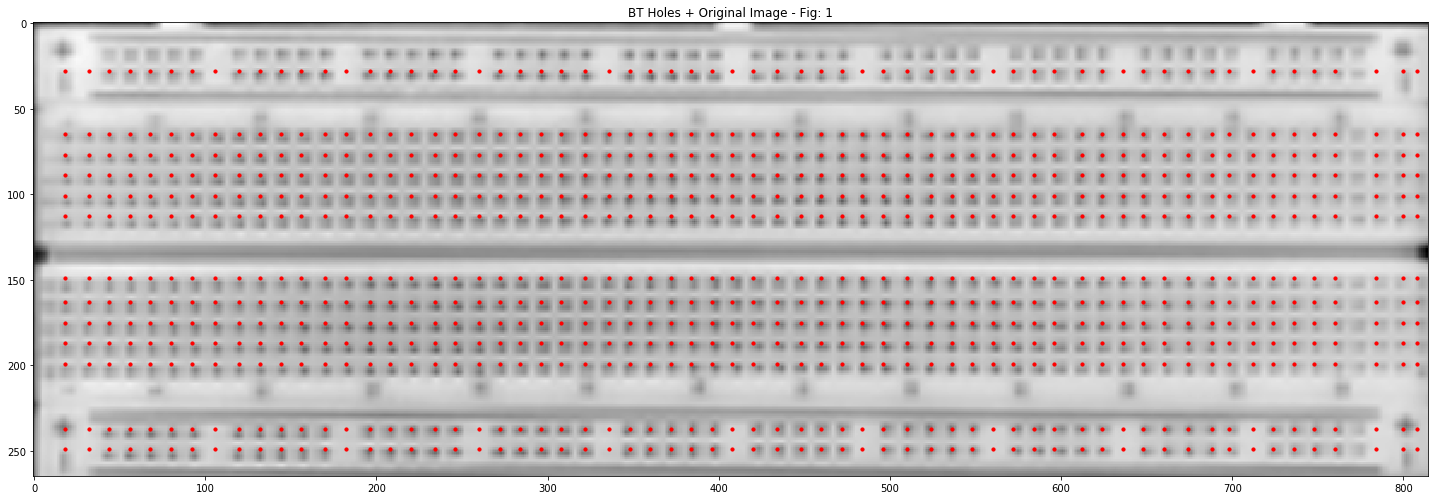

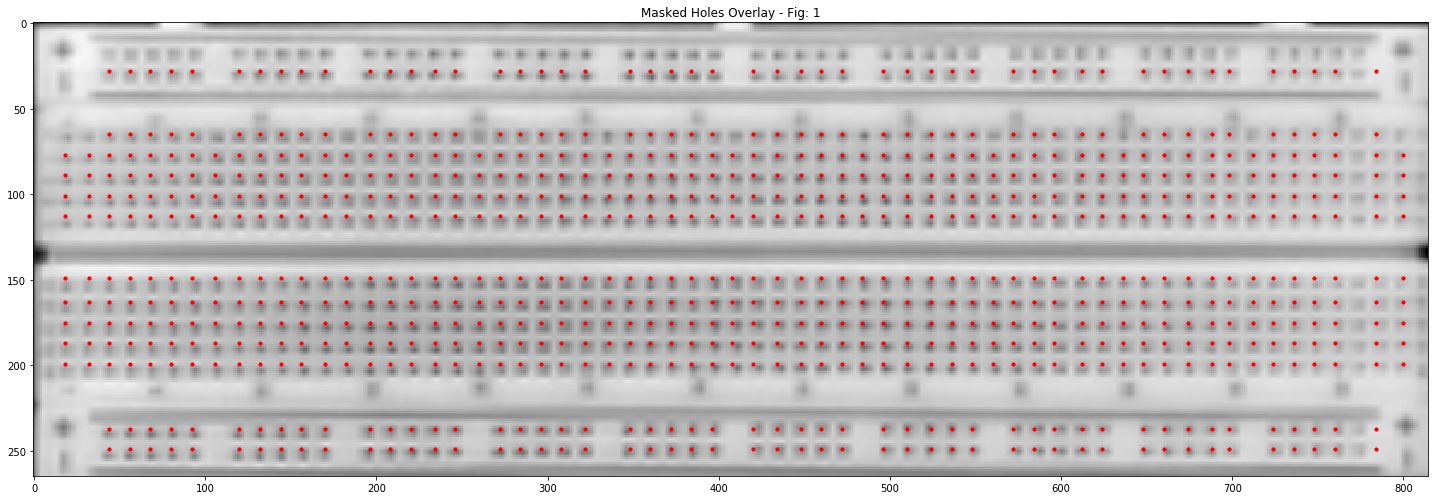

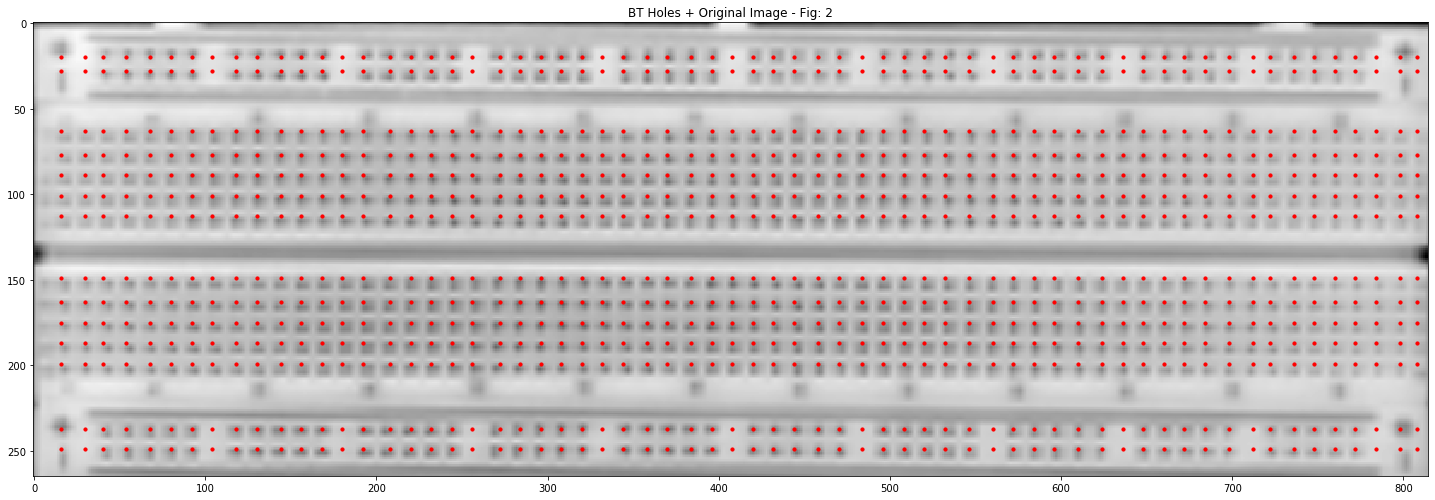

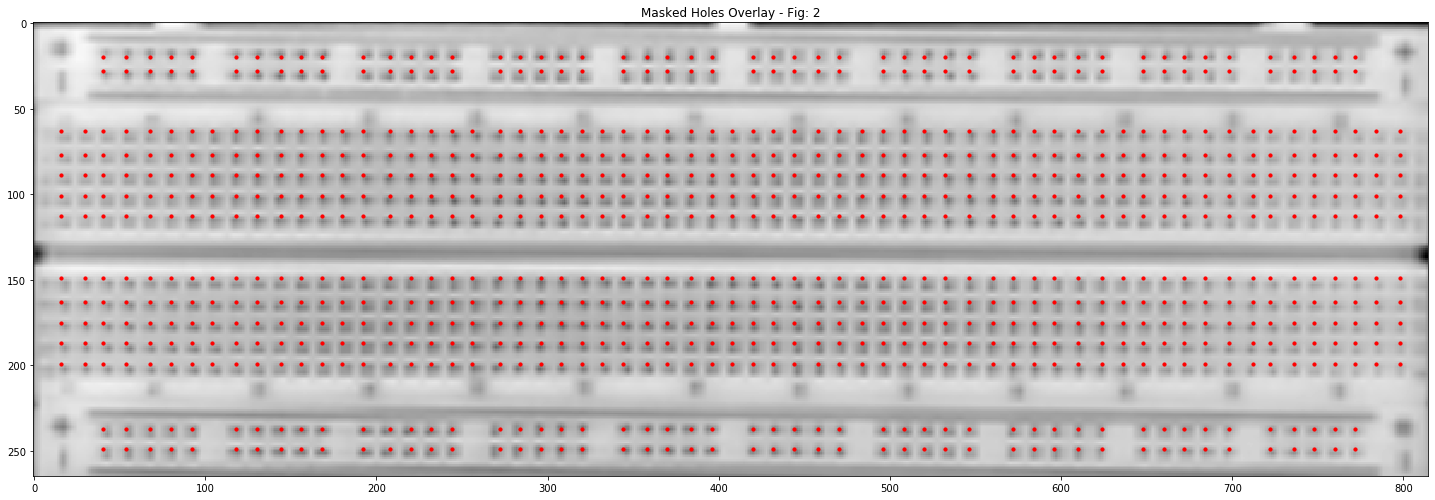

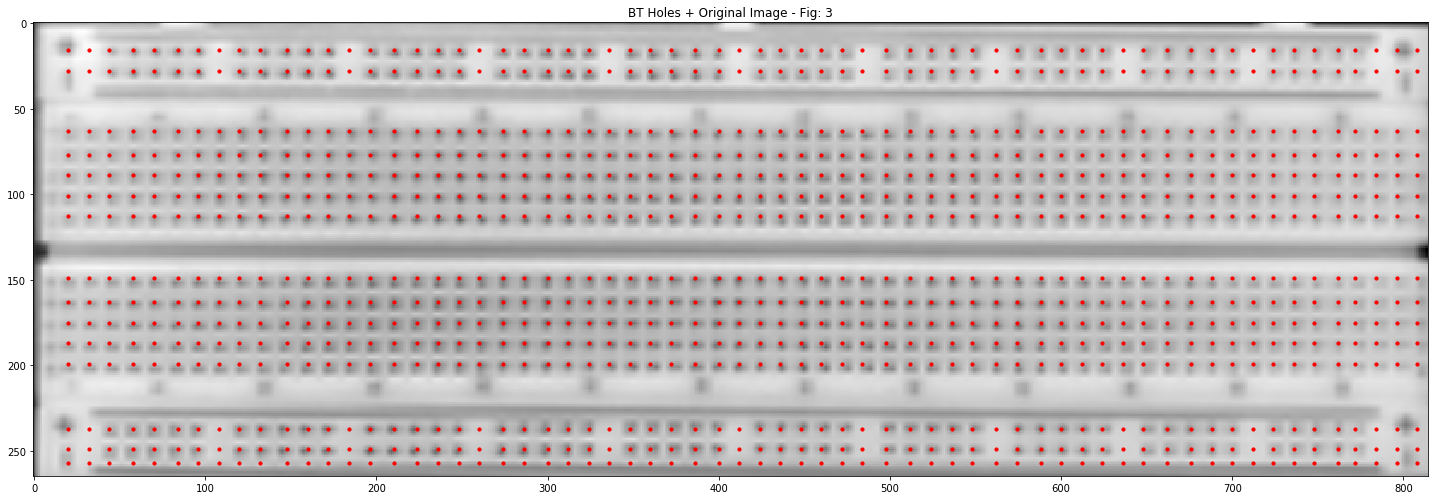

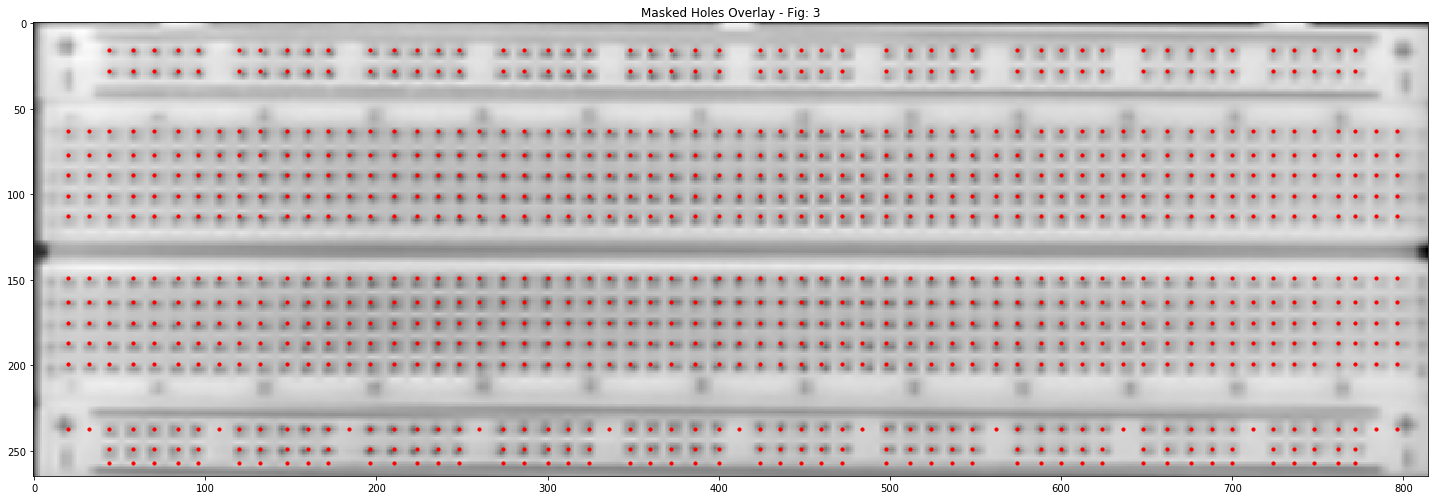

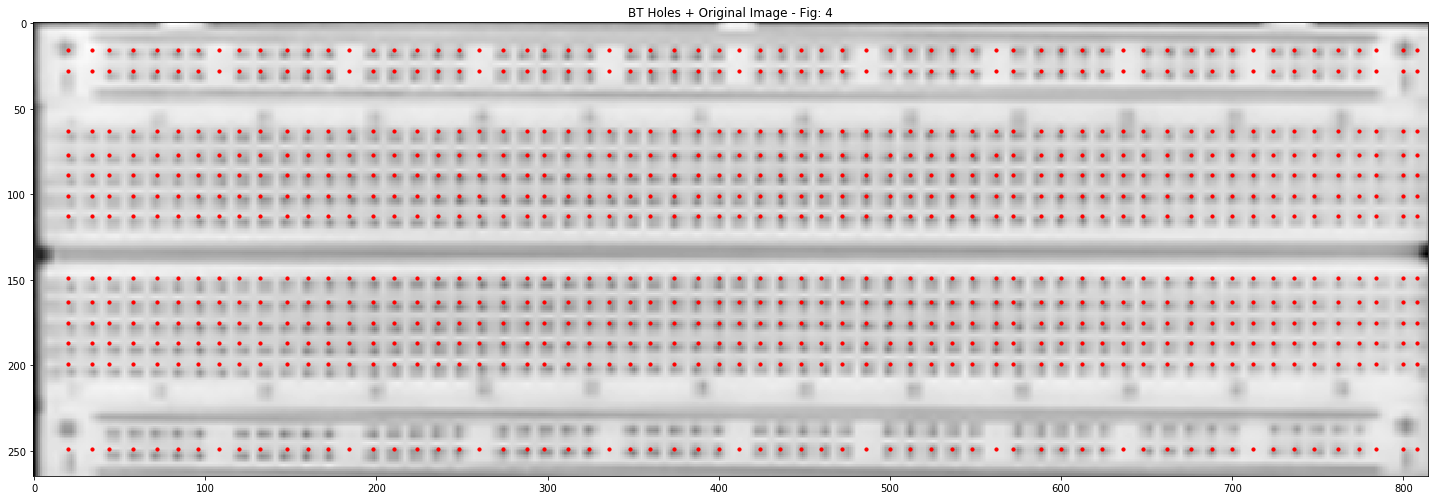

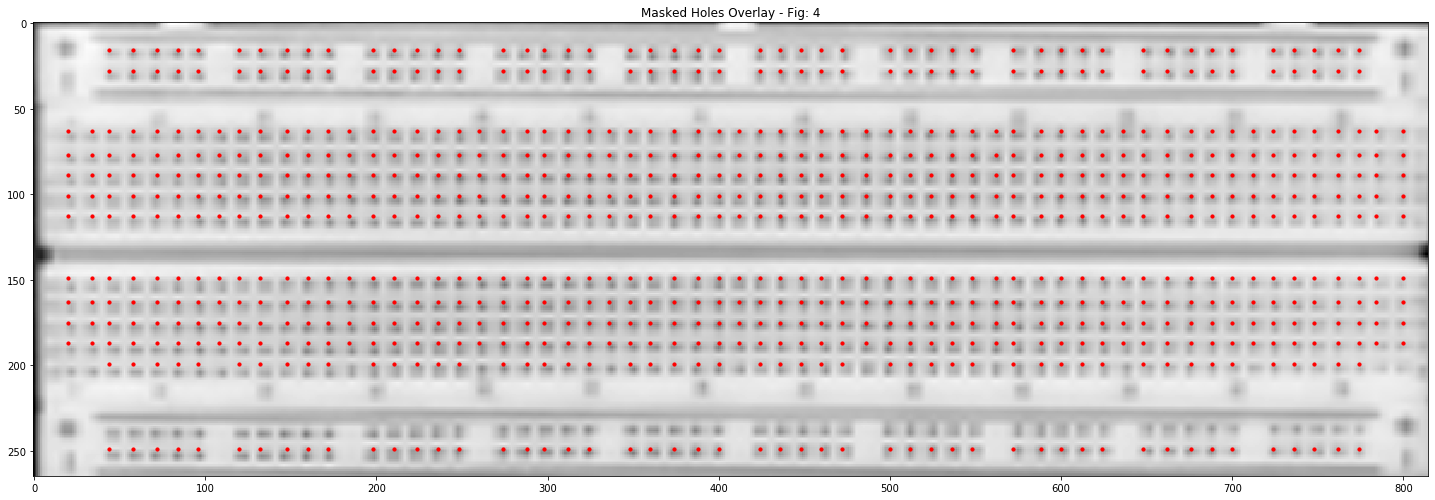

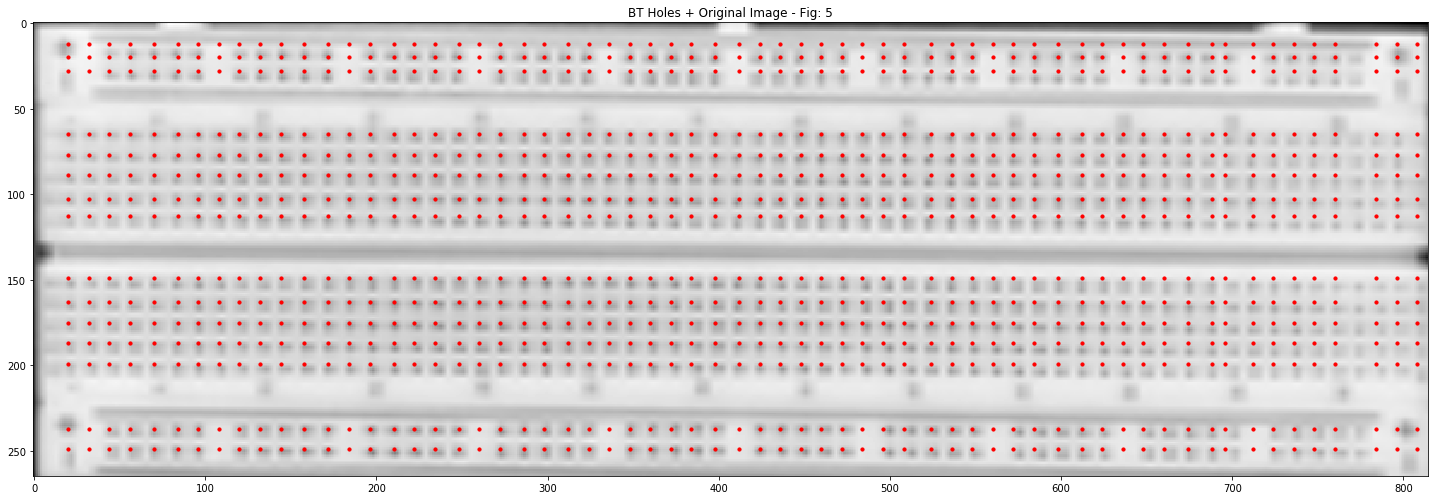

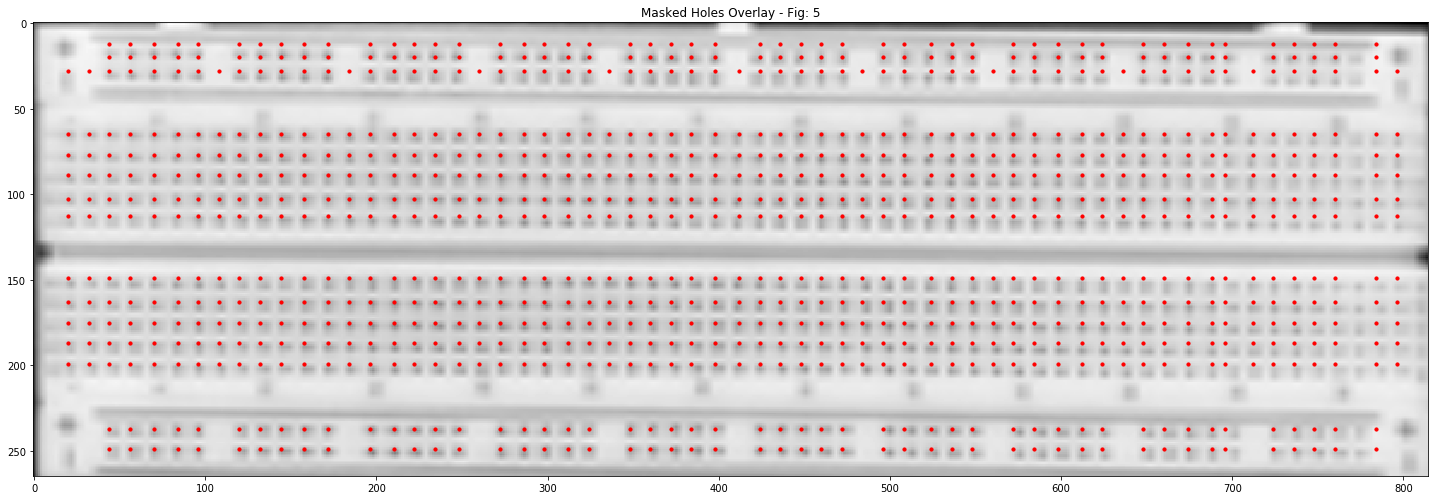

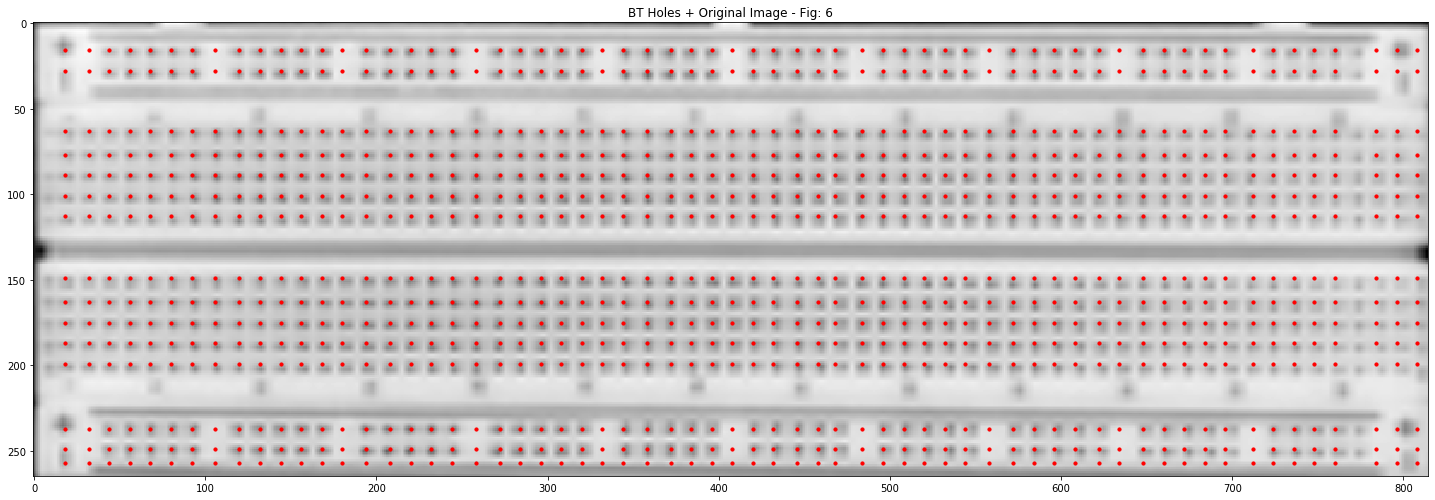

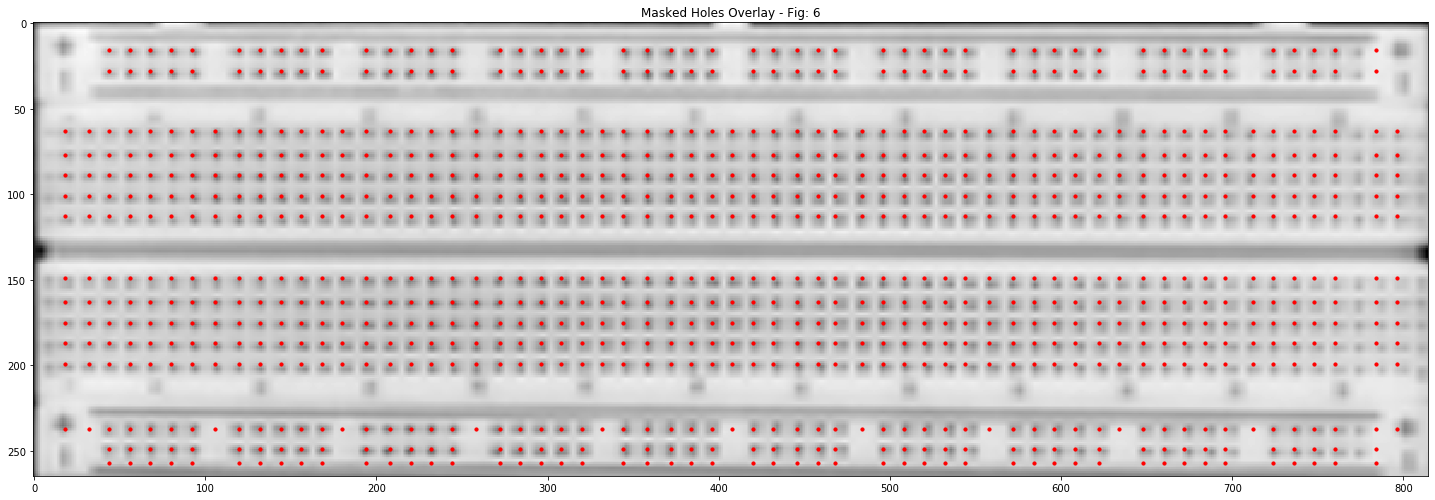

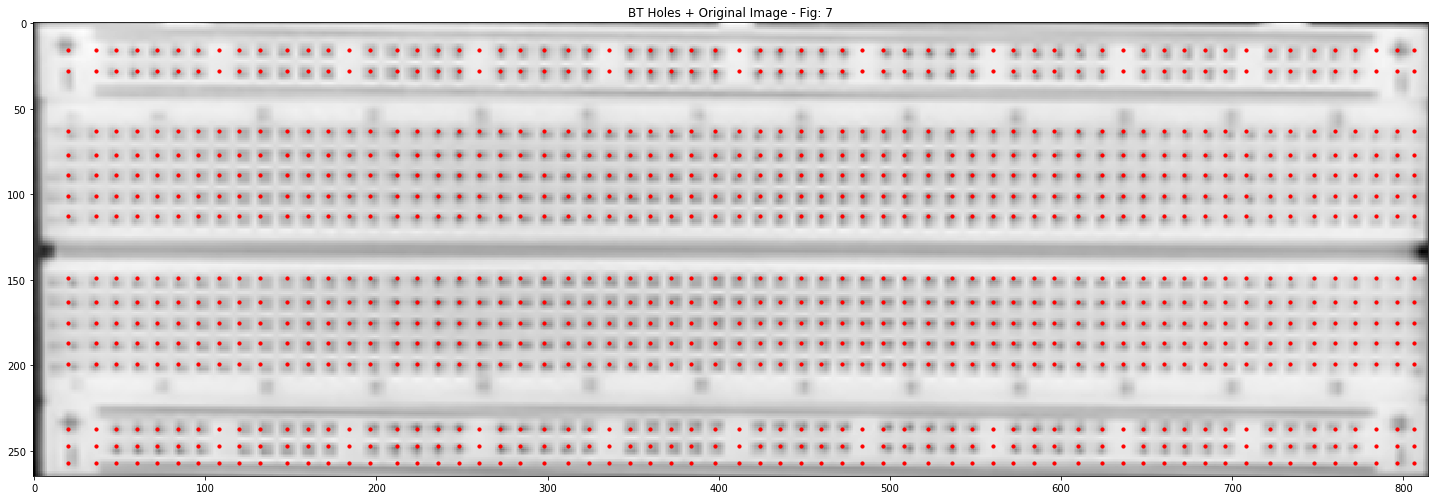

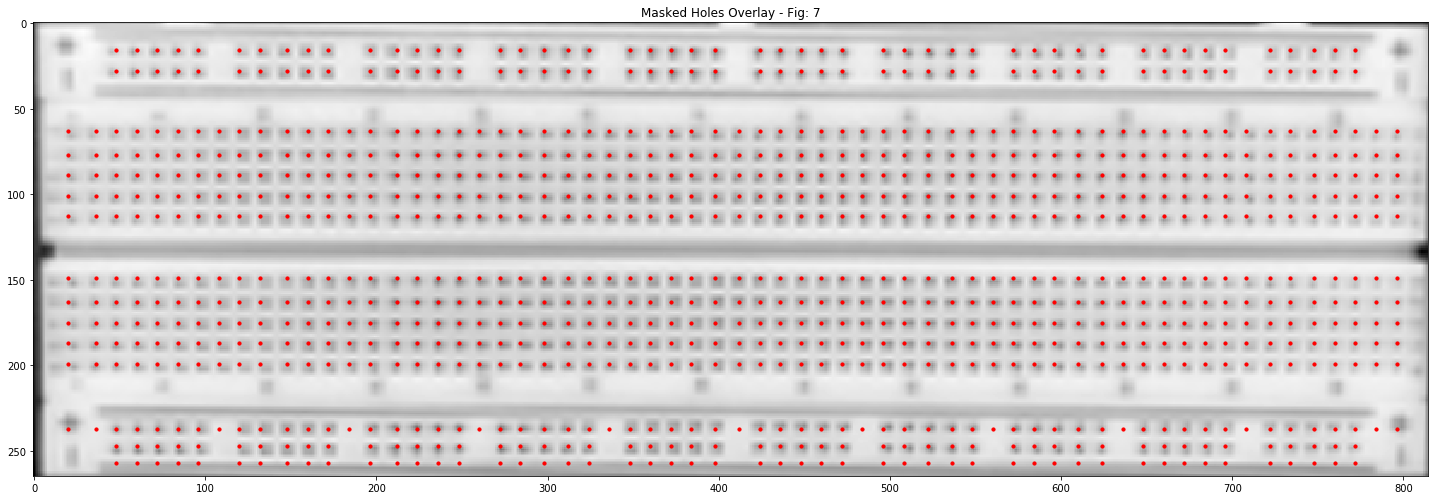

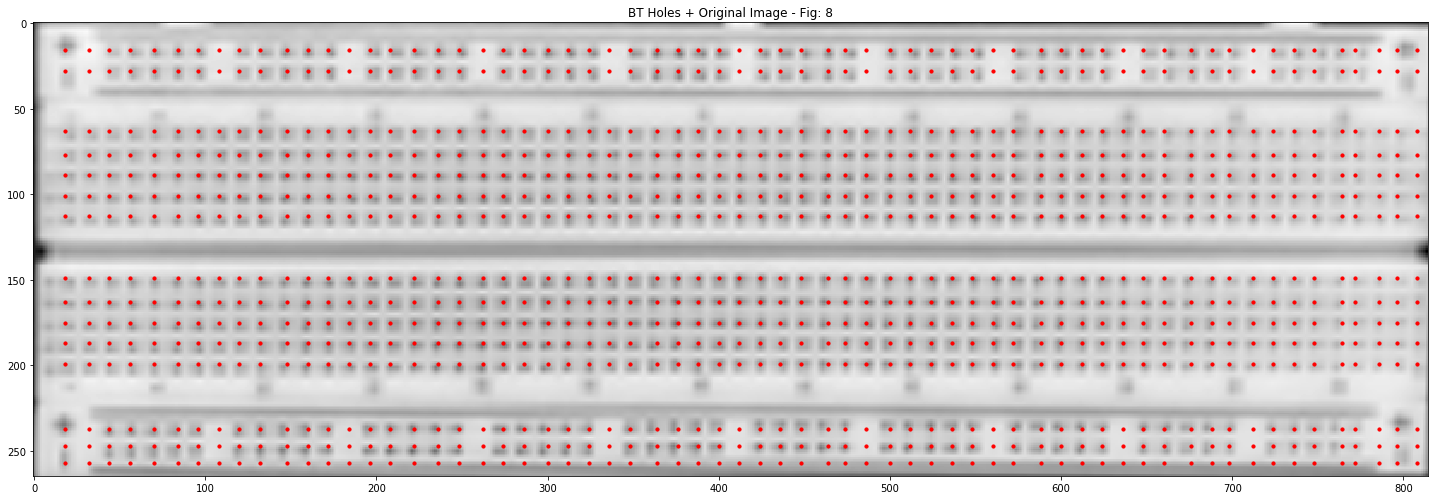

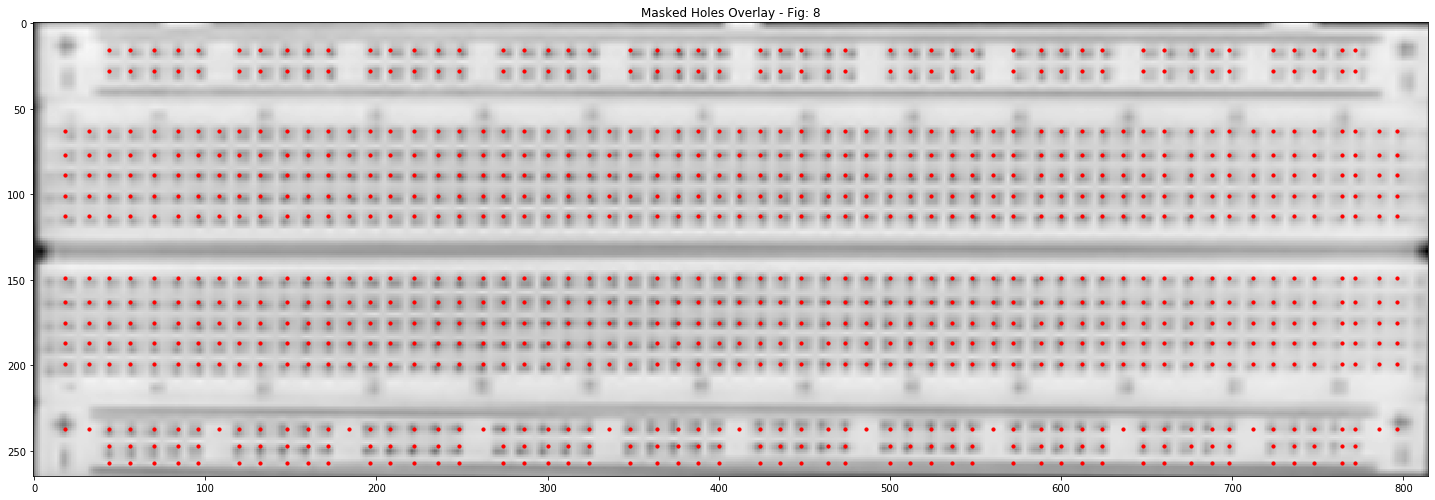

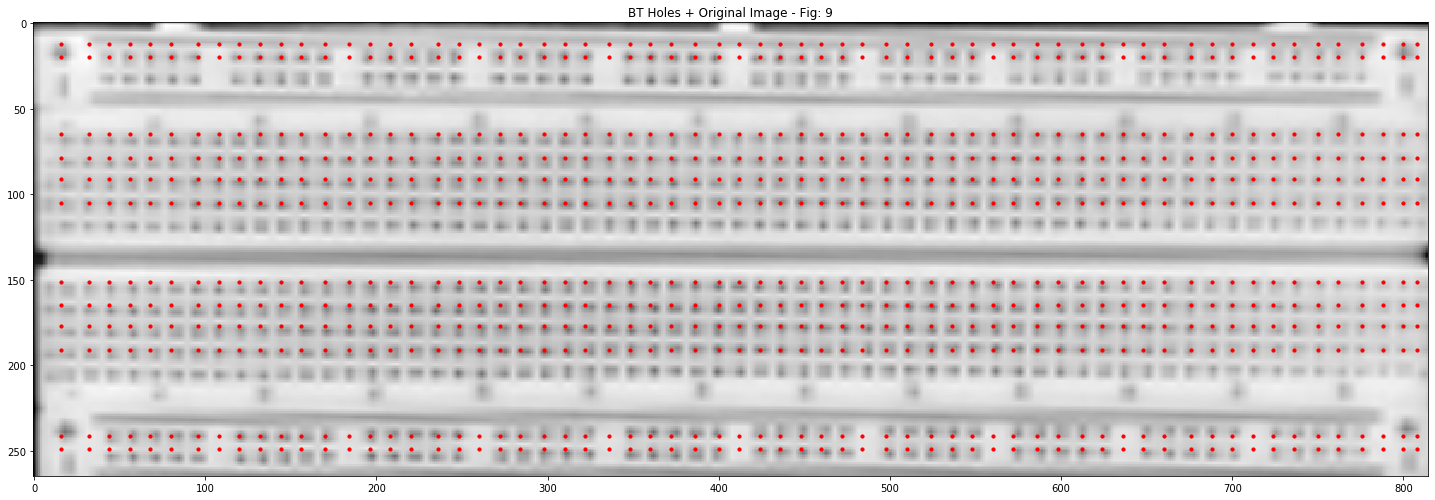

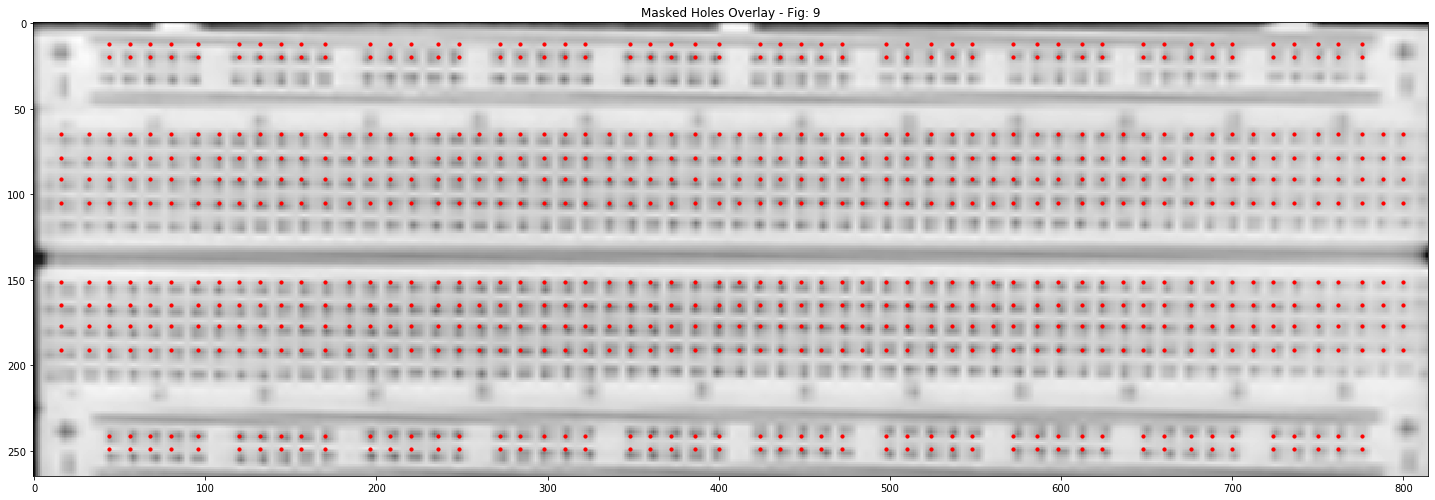

In [22]:
test_lambda_rows = [0.0001, 0.001, 0.01, 0.1]
test_lambda_cols = [0.1, 1, 10, 100]

row_lam = test_lambda_rows[0]
row_col = test_lambda_cols[0]

for num in range(1, 10):
#     print("Board: " + str(num) + ", row_lam: " + str(row_lam) + ", col_lam: " + str(col_lam))
    bread_cols, bread_rows, bread_mat = keyed2holes(num, show_inter_im = False)
    hole_mat =hole_mask(num, bread_cols, bread_rows, bread_mat, show_inter_im = False)